# Подготовка данных для обучения

In [30]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import os
import re

from tqdm.notebook import tqdm

import ssl
ssl._create_default_https_context = ssl._create_stdlib_context

import nltk
#nltk.download('wordnet')
#nltk.download('stopwords')
#nltk.download('twitter_samples')
#nltk.download('gutenberg')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
#from nltk.corpus import gutenberg?
from nltk.corpus import twitter_samples
import gensim

from multiprocessing.dummy import Pool, Queue

import itertools
from scipy.special import softmax
from scipy.stats import median_abs_deviation as mad
from sklearn.cluster import DBSCAN
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor

from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.base import BaseEstimator
from sklearn.neighbors import KNeighborsClassifier, KDTree
from scipy.spatial.distance import euclidean, cosine
from scipy.spatial.distance import cdist
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.svm import OneClassSVM

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score

### Данные

Для ускорения исследования, скачаем весь датасет, и будем собирать батчи из него.

In [31]:
#df = pd.read_csv('datasets/poems_150_5_5.csv', low_memory=False)
df = pd.read_csv('twitter_dataset_4_9000_2000.csv', low_memory=False)
df.drop(columns=['Unnamed: 0'], inplace=True)
df.dropna(inplace=True)

print( df.shape )
print( np.sum( df.novel ) / df.shape[0] )

(14999, 4)
0.020001333422228148


In [32]:
def stream_generator(batch_size=10):
    
    # df = pd.read_csv('twitter_dataset.csv')
    for i in range(0, df.shape[0], batch_size):
        stream_batch = df.iloc[i : min(i + batch_size, df.shape[0])]
        yield stream_batch['content'].tolist(), stream_batch['novel'].tolist()
        
for batch in stream_generator(3):
    print(batch)
    break

(['Tune in 11:30 ET tomorrow for a live webcast of Families USA Presidential Forum on health care: http://presidentialforums.health08.org/', "Iowans, there's a good chance there's a Biden near you today on a cool 14 F day: http://blog.joebiden.com/?p=1625", 'Met with Judge Sotomayor today. Very impressive, experienced judge who is also very down to earth. Will do great work on Supreme Court.'], [0.0, 0.0, 0.0])


### Предобработка

Некоторые стоп-слова удалим. Применим в одном варианте лемматизацию, в другом - стемминг.

In [33]:
class Preprocessor:
    
    def __init__(self):
        self.methods = {
            'lemm' : self.lemmatization,
            'stem' : self.stemming,
            'both' : self.both_norm
        }
        self.lemmatizer = WordNetLemmatizer()
        self.stemmer = PorterStemmer()
        self.swords = set( stopwords.words("english") )
     
    def preprocess1(self, content_batch, standard='both'):
        # stream_batch: ([content], [novel]), content = list(string), novel = list
    
        preprocessed_batch = []
        for doc in content_batch:
            doc = doc.lower()
            #doc = self.delete_tags(doc)
            doc = self.delete_links(doc)
            doc = self.delete_garbage(doc)
            tokens = self.get_tokens(doc)
            tokens = self.methods[standard](tokens)
            tokens = self.delete_stop_words(tokens)
            preprocessed_batch.append( ' '.join(tokens) )
            
        return preprocessed_batch
    
    
    def delete_tags(self, doc):
        # doc = re.sub(r'^@[\w]*', ' ', doc) 
        # doc = re.sub(r'\s@[\w]*', ' ', doc)
        return doc
    
    
    def delete_links(self, doc):
        doc = re.sub(r'http\:\/\/[\w\-&\./?=\+;@#%]*', ' ', doc)
        doc = re.sub(r'https\:\/\/[\w\-&\./?=\+;@#%]*', ' ', doc)
        doc = re.sub(r'ftp\:\/\/[\w\-&\./?=\+;@#%]*', ' ', doc)
        doc = re.sub(r'www\.[\w\-&\./?=\+;@#%]*', ' ', doc)
        return doc
    
    
    def delete_garbage(self, doc):
        doc = re.sub(r'&amp;', ' ', doc)
        doc = re.sub(r'\s+', ' ', doc)
        # doc = re.sub(r"\b\w*\W+\w*\b", ' ', doc)
        doc = re.sub(r"[^a-zA-Z0-9\s]*", '', doc)
        # doc = re.sub(r"\sRT\s ", '', doc)
        return doc
    
    
    def delete_stop_words(self, tokens): # TODO: create own sw list
        return list( filter(lambda sword: sword not in self.swords, tokens) )
    
    
    def get_tokens(self, doc):
        return list(map(lambda token: token.lower(), doc.split()))
    
    
    def lemmatization(self, tokens):
        return list(map(lambda token: self.lemmatizer.lemmatize(token), tokens))
    
    
    def stemming(self, tokens):
        return list( map(lambda token: self.stemmer.stem(token), tokens) )
    
    
    def both_norm(self, tokens):
        tokens = list(map(lambda token: self.lemmatizer.lemmatize(token), tokens))
        return list( map(lambda token: self.stemmer.stem(token), tokens) )

### Словарь

Скачаем корпус из классических произведений, и создадим из него фиксированный словарь для векторизации.

In [34]:
def create_vocab():
    twitter_samples.fileids()
    vocab_corpus = ([(t, "pos") for t in twitter_samples.strings("positive_tweets.json")] + 
             [(t, "neg") for t in twitter_samples.strings("negative_tweets.json")] +
             [(t, "neg") for t in twitter_samples.strings("tweets.20150430-223406.json")]
            )
    vocab_corpus = list( map( lambda pair: pair[0], vocab_corpus ) )
    return vocab_corpus

vocab_corpus = create_vocab()

pp = Preprocessor()
vocab_corpus = pp.preprocess1(vocab_corpus)

print( len(vocab_corpus) )
print( vocab_corpus[0] )

30000
followfriday franceint pkuchly57 milipolpari top engag member commun thi week


### Векторизация

Класс, в котором будут реализованы основные методы векторизации.

In [35]:
class Vectorizer():
    
    def __init__(self, method, train_corpus):
        self.methods = {
            'one-hot' : self.one_hot_vectorizer,
            'count' : self.count_vectorizer,
            'tf-idf' : self.tfidf_vectorizer,
            #'n-gramms' : self.n_gramms_vectorizer,
            'doc-to-vec' : self.doc_to_vec_vectorizer
        }
        if method not in self.methods:
            raise Exception('Wrong method: {}'.format(method))
        
        self.method = method
        self.model = None
        self.train_corpus = Preprocessor().preprocess1( train_corpus )
        
    
    def vectorize(self, batch, **args):
        return self.methods[self.method](batch, **args)
        
    
    def one_hot_vectorizer(self, batch, **args):
        
        if self.model is None:
            self.model = CountVectorizer(binary=True, **args)
            self.model.fit(self.train_corpus)
            
        return self.model.transform(batch)
    
    
    def count_vectorizer(self, batch, **args):
        
        if self.model is None:
            self.model = CountVectorizer(**args)
            self.model.fit(self.train_corpus)
            
        return self.model.transform(batch)
    
    
    def tfidf_vectorizer(self, batch, **args):
        
        if self.model is None:
            self.model = TfidfVectorizer(**args)
            self.model.fit(self.train_corpus)
            
        return self.model.transform(batch)
        
        
    def doc_to_vec_vectorizer(self, batch, **args):
        
        def extract_tokens(train = False):
            if train:
                for i, doc in enumerate(self.train_corpus):
                    tokens = Preprocessor().get_tokens(doc)
                    yield gensim.models.doc2vec.TaggedDocument(tokens, [i])    
                    
            else:
                for i, doc in enumerate(batch):
                    tokens = Preprocessor().get_tokens(doc)
                    yield tokens

        
        if self.model is None:
            # vocab = list( extract_tokens(train=True) )
            vocab = list( extract_tokens(train=True) )
            self.model = gensim.models.doc2vec.Doc2Vec(min_count=1, vector_size=1000, epochs=20, )
            # self.model.build_vocab(train_corpus, update = True)
            # self.model.build_vocab(self.train_corpus)
            self.model.build_vocab( vocab )
            self.model.train(vocab, total_examples=self.model.corpus_count, epochs=20, **args)
        
        return np.array( list( map( lambda token: self.model.infer_vector(token), extract_tokens() ) ) )

### Визуализируем на плоскости

In [7]:
pp = Preprocessor()
v1 = Vectorizer('tf-idf', vocab_corpus)

In [14]:
n_iter = 500
n_jobs = 4

In [15]:
X = df['content'].tolist()
X = pp.preprocess1(X)
X = v1.vectorize(X)
Xe = TSNE(n_components=2, n_iter=n_iter, n_jobs=n_jobs, verbose=1).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 14999 samples in 0.001s...
[t-SNE] Computed neighbors for 14999 samples in 21.134s...
[t-SNE] Computed conditional probabilities for sample 1000 / 14999
[t-SNE] Computed conditional probabilities for sample 2000 / 14999
[t-SNE] Computed conditional probabilities for sample 3000 / 14999
[t-SNE] Computed conditional probabilities for sample 4000 / 14999
[t-SNE] Computed conditional probabilities for sample 5000 / 14999
[t-SNE] Computed conditional probabilities for sample 6000 / 14999
[t-SNE] Computed conditional probabilities for sample 7000 / 14999
[t-SNE] Computed conditional probabilities for sample 8000 / 14999
[t-SNE] Computed conditional probabilities for sample 9000 / 14999
[t-SNE] Computed conditional probabilities for sample 10000 / 14999
[t-SNE] Computed conditional probabilities for sample 11000 / 14999
[t-SNE] Computed conditional probabilities for sample 12000 / 14999
[t-SNE] Computed conditional probabilities for sa

In [16]:
df.head(2)

,time,content,novel,type
0,2007-10-24 22:45:57+00:00,Tune in 11:30 ET tomorrow for a live webcast o...,0.0,4.0
1,2007-12-29 15:35:26+00:00,"Iowans, there's a good chance there's a Biden ...",0.0,4.0


In [17]:
def show_clusters(Xe):
    plt.figure(figsize=(14,9))
    types = df['type'].nunique()
    
    for i in range(1, 5):
        mask = (df['type'] == i).astype(dtype=int).to_numpy()
        Xi = Xe[np.where(mask)]
        plt.scatter(Xi[:, 0], Xi[:, 1])

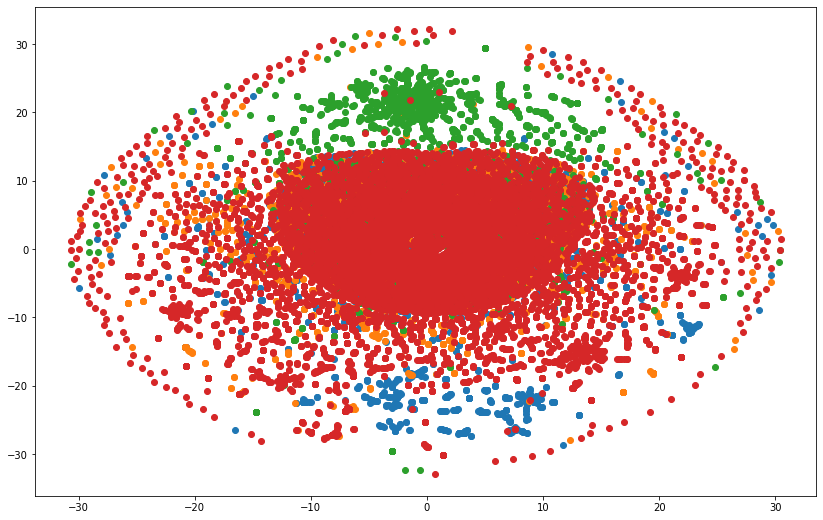

In [18]:
show_clusters(Xe)

plt.show()

В данной визуалиции кластеры разных тем никак не отделены друг от друга. Посмотрим, как с этим справятся алгоритмы.

## Алгоритмы

Результаты замеров есть в таблице:

https://docs.google.com/spreadsheets/d/1a6M76eS8L-WTGKVI-xRajut2P-X70j-bv5s_7WZv3ZE/edit?usp=sharing

In [36]:
def run_scores(pipeline, batch_size, n_start, return_target=False):
    """
        pipeline: pp, alg, svd, vectorizer
        return: accuracy, precision, recall, roc_auc, [answers, targets, scores]
    """
    
    pp, alg, svd, vectorizer = pipeline
    
    answers = []
    targets = []

    for batch, target in tqdm( stream_generator(batch_size) ):
        batch = pp.preprocess1(batch)
        vectors = vectorizer.vectorize(batch)
        if svd is not None:
            vectors = svd.fit_transform(vectors)
            
        answers += list( alg.predict(vectors) ) 
        targets += target
    
    answers = answers[n_start:]
    targets = targets[n_start:]
    
    try:
        roc_auc = roc_auc_score(targets, answers)
    except:
        roc_auc = 0.5
        
    result = [roc_auc]
    
    if return_target:
        result += [answers, targets]
    
    return result

In [37]:
def combine_params(*args):
    return list( itertools.product(*args) )


def pool_process(params, run_with_param):
    
    def process_run(arg):
        i, run_with_param = arg

        #with open('data/poems{:05d}.txt'.format(i), mode='w') as txt:
        while not queue.empty():
            ind = queue.get()
            cur_param = params[ind]
        
            try:
                roc_auc = run_with_param(cur_param)
            except Exception as err:
                roc_auc = -1
                with lock:
                    print('process: {}; error: {}; \nparams: {}'.format( i, err, cur_param))

            with lock:
                print(cur_param)
                print('ROC AUC: {}'.format(roc_auc))
                print()
                pbar.update(1)
    
    
    queue = Queue()

    params_ind = np.arange(len(params))
    for i in params_ind:
        queue.put(i)

    with Pool(processes=4) as pool, tqdm(total=queue.qsize()) as pbar:
        lock = pbar.get_lock()
        pool.map(process_run, zip(range(pool._processes), [run_with_param] * len(range(pool._processes)) ))

    pool.join()

### Базовый класс для алгоритмов

In [38]:
class Storage:
    
    def __init__(self, n_start, max_samples):
        self.data = None
        self.pos = 0
        self.initialized = False
        self.max_samples = max_samples
        self.n_for_start = n_start
        
        if self.n_for_start > self.max_samples:
            self.n_for_start = self.max_samples
            print('n_start set to max_samples')
            
    def update_storage(self, X, start_count): # Warning: copying removed 
        
        if self.data.shape[0] == self.max_samples:
            
            if self.pos + X.shape[0] - start_count <= self.max_samples:
                self.data[self.pos : self.pos + X.shape[0] - start_count] = X[start_count : ] # .copy()
                self.pos += X.shape[0] - start_count

            else:
                self.data[self.pos : ] = X[start_count : start_count + self.data.shape[0] - self.pos] # .copy()
                start_count += self.data.shape[0] - self.pos
                self.pos = 0
                self.data[self.pos : self.pos + X.shape[0] - start_count] = X[start_count :] # .copy()
        
        else:
            
            if self.pos + X.shape[0] - start_count <= self.max_samples:
                self.data = np.concatenate((self.data, X[start_count : ]), axis=0)
                self.pos += X.shape[0] - start_count

            else:
                self.data = np.concatenate((self.data,
                                            X[start_count : start_count + self.data.shape[0] - self.pos]), axis=0)
                start_count += self.data.shape[0] - self.pos
                self.pos = 0
                self.data[self.pos : self.pos + X.shape[0] - start_count] = X[start_count :] # .copy()
    
    
    def check_consistency(self, X):
        if X.shape[0] > self.max_samples:
            raise Exception('Too large batch for this model. Fix max_samples')
    
    
    def reset(self):
        self.data = None
        self.pos = 0
        self.initialized = False

In [39]:
class NovelPredictor(BaseEstimator):
    """
        all algorithms must contain fit and predict methods
        all sons must implement 'decision_function' method
    """
    def __init__(self, alg, n_start=100, max_samples = 1000 ):
        self.storage = Storage(n_start, max_samples)
        self.alg = alg
        self.novelty_label = 1
    
    def predict(self, X):
        
        X = np.asarray(X)
        
        self.storage.check_consistency(X)
        start_count = 0
        
        if not self.storage.initialized:
            X = np.asarray(X, dtype = X.dtype)
            start_count = min( self.storage.n_for_start, X.shape[0])
            self.storage.data = X[:start_count]
            self.storage.pos = start_count % self.storage.max_samples
            self.storage.initialized = True
        
        targets = []
        if start_count < X.shape[0]:
 
            # self.storage.update_storage(X, start_count) # TODO: так после же надо?
            self.alg.fit(self.storage.data)
            # print(len( self.decision_function( self.alg.predict(X[start_count:]) ) ), start_count)
            predict = self.decision_function( self.alg.predict(X[start_count:]) )
            targets = [self.novelty_label] * start_count + predict # SHOULD BE LIST!
            self.storage.update_storage(X, start_count) # TODO: так после же надо?
            
        else:
            targets = [self.novelty_label] * start_count
        
        return targets
    

    def reset(self):
        self.storage.reset()

### IQR

In [40]:
class IQR:
    def __init__(self):
        pass
    def fit(self, X, y=None):
        self.X = X.copy()
    def predict(self, X, y=None):
        q75, q25 = np.percentile(self.X, [75, 25], axis=0)
        iqr = q75 - q25
        scores = np.where( (X > q25 - 1.5 * iqr).astype(int) * (X < q75 + 1.5 * iqr).astype(int) == 1, 0, 1)
        scores = np.sum( scores, axis=1 )
        #return np.where(scores > 0, 1, 0)
        return softmax( scores ) # неверно. Нужно сначала собрать все скоры, потом сделать predict


class IQRModel(NovelPredictor):
    
    def __init__(self, n_start=100, max_samples = 500):
        
        alg = IQR()
        super().__init__(alg, n_start, max_samples)
        
    def decision_function(self, predict):
        if not isinstance(predict, list):
            return predict.tolist()
        
        return predict

In [29]:
pp = Preprocessor()
# svd = TruncatedSVD(n_components=10, n_iter=7, random_state=42)
vectorizer = Vectorizer('tf-idf', vocab_corpus)
n_start = 100
for n_components in [5, 10, 20]:
    #svd = LDA(n_components=n_components)
    svd = NMF(n_components=n_components, init='random', max_iter=1000, random_state=0)
    try:
        alg = IQRModel(max_samples=500, n_start=n_start)
        pipeline = [pp, alg, svd, vectorizer]
        roc_auc = run_scores(pipeline, batch_size=500, n_start=n_start,
                                return_target=False)
        print('No param', '|', roc_auc)

    except Exception as err:
        print(err)


No param | [0.4508625019978537]



No param | [0.5146157271045962]


KeyboardInterrupt: 

In [83]:
tparams = combine_params([6, 10, 20, 50])
print(tparams)

[(6,), (10,), (20,), (50,)]


In [84]:
def iqr_run(cur_params):
    pp = Preprocessor()
    vectorizer = Vectorizer('tf-idf', vocab_corpus)
    n_start = 100
    n_components = cur_params[0]
    
    # print('param: ', cur_params)
    
    svd = LDA(n_components=n_components)
    try:
        alg = IQRModel(max_samples=500, n_start=n_start)
        pipeline = [pp, alg, svd, vectorizer]
        roc_auc = run_scores(pipeline, batch_size=500, n_start=n_start,
                                return_target=False)
    except Exception as err:
        roc_auc = -1
        
    return roc_auc

In [87]:
pool_process(tparams, iqr_run)

(6,)
ROC AUC: [0.7489268671370185]

(10,)
ROC AUC: [0.6591582756809826]

(20,)
ROC AUC: [0.5891655821174967]

(50,)
ROC AUC: [0.5625006278968879]




In [89]:
for params in tqdm(tparams):
    iqr_run(params)

### DBSCAN

In [41]:
class DbscanWrapper:
    def __init__(self, eps, min_samples):
        self.alg = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
        
    def fit(self, X, y=None):
        self.X = X
        
    def predict(self, X, y=None):
        self.alg.fit( np.concatenate( (self.X, X), axis=0) )
        return np.where( self.alg.labels_[self.X.shape[0]:] < 0, 1, 0)


class Dbscan(NovelPredictor):
    
    def __init__(self, n_start=100, max_samples = 500, eps=0.4, min_samples=10):
        
        alg = DbscanWrapper(eps=eps, min_samples=min_samples)
        super().__init__(alg, n_start, max_samples)
        
    def decision_function(self, predict):
        return predict.tolist() 

In [44]:
pp = Preprocessor()
# svd = TruncatedSVD(n_components=10, n_iter=7, random_state=42)

vectorizer = Vectorizer('tf-idf', vocab_corpus)
n_start = 100

ans, tar = [], []
for n_components in [5]:
    # svd = LDA(n_components=n_components)
    # svd = TruncatedSVD(n_components=n_components, n_iter=7, random_state=42)
    svd = NMF(n_components=n_components, init='random', max_iter=1000, random_state=0)
    for min_samples in [5]:
        for eps in np.linspace(0.001, 0.01, 19): # 0.3 best

            try:
                alg = Dbscan(max_samples=500, eps=eps, min_samples=min_samples)
                pipeline = [pp, alg, svd, vectorizer]
                roc_auc, ans, tar = run_scores(pipeline, batch_size=500, n_start=n_start,
                                             return_target=True)

                print(n_components, min_samples, eps, '|', roc_auc)

            except Exception as err:
                print(err)


5 5 0.001 | 0.3953439733315067



5 5 0.0015 | 0.4451439596319382



5 5 0.002 | 0.472693677649154



5 5 0.0025 | 0.49403178299883554



5 5 0.003 | 0.5047530652784438



5 5 0.0035 | 0.5049599287622439



5 5 0.004 | 0.5026550905313149



5 5 0.0045000000000000005 | 0.5107608968650821



5 5 0.005 | 0.5097683631298948



5 5 0.0055000000000000005 | 0.5092322533506861



5 5 0.006 | 0.5119267301413338



5 5 0.0065 | 0.513936228508802



5 5 0.007 | 0.5111054410119414



5 5 0.007500000000000001 | 0.5142905906797269



5 5 0.008 | 0.5176127360321483



5 5 0.0085 | 0.5181037513984976


KeyboardInterrupt: 

### Elliptical Envelope

In [45]:
class EllipseWrapper:
    
    def __init__(self, contamination):
        self.alg = EllipticEnvelope(contamination=contamination)
        
    def fit(self, X, y=None):
        self.alg.fit(X)
    
    def predict(self, X):
        return -alg.decision_function(X)
        #return 1 - softmax( alg.decision_function(X) )

class Ellipse(NovelPredictor):
    
    def __init__(self, contamination, n_start=100, max_samples = 500):
        
        alg = EllipticEnvelope(contamination=contamination)
        super().__init__(alg, n_start, max_samples)
        
    def decision_function(self, predict):
        return predict.tolist()
        #return np.where( predict < 0, 1, 0).tolist()

In [ ]:
# alg = EllipticEnvelope(contamination=0.1)
# alg.fit( [[1,2,3], [4,5,6], [7,8,9]] )
# alg.mahalanobis([[1,2,3], [4,5,6], [7,8,9]])

# print( alg.decision_function([[1,2,3], [4,5,6], [7,8,9], [100,100,100], [-200, -20, 0]]) )
# print( alg.mahalanobis([[1,2,3], [4,5,6], [7,8,9], [100,100,100], [-200, -20, 0]]) )
# print( alg.predict([[1,2,3], [4,5,6], [7,8,9], [100,100,100], [-200, -20, 0]]) )

# xx = np.arange(3000).reshape(1000, 3)
# a0 = alg.decision_function(xx)
# a1 = alg.predict(xx)

# (1 - softmax(a0))[:10]
#roc_auc_score(a1, a0)

In [50]:
pp = Preprocessor()
#svd = TruncatedSVD(n_components=10, n_iter=7, random_state=42)
vectorizer = Vectorizer('tf-idf', vocab_corpus)
n_start = 100

for n_components in [10]:
    #svd = LDA(n_components=n_components)
    svd = NMF(n_components=n_components, init='random', max_iter=1000, random_state=0)
    # svd = TruncatedSVD(n_components=n_components, n_iter=7, random_state=42)
    for contamination in np.linspace(0.4, 0.8, 20):

        try:
            alg = Ellipse(max_samples=500, contamination=contamination)
            pipeline = [pp, alg, svd, vectorizer]
            roc_auc = run_scores(pipeline, batch_size=500, n_start=n_start,
                                         return_target=False)

            print(n_components, contamination, '|', roc_auc)

        except Exception as err:
            raise err
           # print(err)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/covariance/_robust_covariance.py:166: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-149.068582833826440 > -542.418746317491241). You may want to try with a higher value of support_fraction (current value: 0.512).
  warnings.warn("Determinant has increased; this should not happen: "



10 0.4 | [0.5695044181108294]



10 0.4210526315789474 | [0.5717089070027628]


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/covariance/_robust_covariance.py:166: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-149.068582833826440 > -542.418746317491241). You may want to try with a higher value of support_fraction (current value: 0.512).
  warnings.warn("Determinant has increased; this should not happen: "



10 0.4421052631578948 | [0.579792337374706]



10 0.4631578947368421 | [0.5889144233623308]



10 0.4842105263157895 | [0.5944064661963149]



10 0.5052631578947369 | [0.6025122725300819]



10 0.5263157894736843 | [0.6070904399844739]



10 0.5473684210526316 | [0.6157211681165378]


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/covariance/_robust_covariance.py:166: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-149.068582833826440 > -542.418746317491241). You may want to try with a higher value of support_fraction (current value: 0.512).
  warnings.warn("Determinant has increased; this should not happen: "



10 0.5684210526315789 | [0.6166577619471654]



10 0.5894736842105264 | [0.6196947279494031]


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/covariance/_robust_covariance.py:166: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-149.068582833826440 > -542.418746317491241). You may want to try with a higher value of support_fraction (current value: 0.512).
  warnings.warn("Determinant has increased; this should not happen: "



10 0.6105263157894737 | [0.6231084320843893]


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/covariance/_robust_covariance.py:166: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-130.702664898530429 > -701.884030135795570). You may want to try with a higher value of support_fraction (current value: 0.512).
  warnings.warn("Determinant has increased; this should not happen: "



10 0.631578947368421 | [0.6274353266205447]



10 0.6526315789473685 | [0.6307462839920542]



10 0.6736842105263159 | [0.6312261113774916]


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/covariance/_robust_covariance.py:166: RuntimeWarning: Determinant has increased; this should not happen: log(det) > log(previous_det) (-133.818820940506185 > -528.929261747381133). You may want to try with a higher value of support_fraction (current value: 0.512).
  warnings.warn("Determinant has increased; this should not happen: "



10 0.6947368421052631 | [0.6339090576980159]



10 0.7157894736842105 | [0.634971116743156]



10 0.736842105263158 | [0.6338870242254036]



10 0.7578947368421053 | [0.63528004201201]



10 0.7789473684210526 | [0.6269470511678882]



10 0.8 | [0.6167534306002694]


### Z-score

In [99]:
class ZModel:
    def __init__(self, eps=1e-6): # threshold,
        self.eps = eps
        #self.threshold = threshold
    def fit(self, X, y=None):
        self.X = X
    def predict(self, X, y=None):
        nX = (X - np.mean(self.X, axis=0)) / np.std( np.where(X > self.eps, X, self.eps), axis=0 )
        return (nX ** 2).sum(axis=1).astype(int)
        #novel = np.where( np.absolute(nX) > self.threshold, 1, 0)
        #return novel.any(axis=1).astype(int)

    
class ZScore(NovelPredictor):
    
    def __init__(self, n_start=100, max_samples = 500): # threshold,
        
        alg = ZModel()
        super().__init__(alg, n_start, max_samples)
        
    def decision_function(self, predict):
        return predict.tolist()

In [100]:
pp = Preprocessor()
#svd = TruncatedSVD(n_components=10, n_iter=7, random_state=42)
vectorizer = Vectorizer('tf-idf', vocab_corpus)
n_start = 100

for n_components in [6, 10, 20]:
    svd = LDA(n_components=n_components)
    try:
        alg = ZScore(max_samples=500) # , threshold=threshold
        pipeline = [pp, alg, svd, vectorizer]
        roc_auc = run_scores(pipeline, batch_size=500, n_start=n_start, return_target=False)

        print(n_components, '|', roc_auc)

    except Exception as err:
        print(err)


6 | [0.43996677854647587]



10 | [0.4874341849898395]



20 | [0.4164415370915816]


### Median Z-score

In [103]:
class MZModel:
    def __init__(self, eps=1e-6): #  threshold,
        self.eps = eps
        #self.threshold = threshold
        # assert threshold > 0
        
    def fit(self, X, y=None):
        self.X = X
        
    def predict(self, X, y=None):
        nX = (X - np.median(self.X, axis=0)) / mad( np.where(X > self.eps, X, self.eps), axis=0 )
        return (nX ** 2).sum(axis=1).astype(int)
        #novel = np.where( np.absolute(nX) > self.threshold, 1, 0)
        #return novel.any(axis=1).astype(int)

    
class MZScore(NovelPredictor):
    
    def __init__(self, n_start=100, max_samples=500):
        
        alg = MZModel()
        super().__init__(alg, n_start, max_samples)
        
    def decision_function(self, predict):
        return predict.tolist()

In [104]:
pp = Preprocessor()
# svd = TruncatedSVD(n_components=10, n_iter=7, random_state=42)
vectorizer = Vectorizer('tf-idf', vocab_corpus)
n_start = 100

for n_components in [6, 10, 20]:
    svd = LDA(n_components=n_components)
    
    try:
        alg = MZScore(max_samples=500)
        pipeline = [pp, alg, svd, vectorizer]
        roc_auc = run_scores(pipeline, batch_size=500, n_start=n_start, return_target=False)

        print('No param', '|', roc_auc)

    except Exception as err:
        print(err)


No param | [0.29327237025367037]



No param | [0.2192377331780716]



No param | [0.2664522684202114]


### LOF

In [15]:
class LOFWrapper:
    def __init__(self, n_neighbors, contamination):
        self.alg = LocalOutlierFactor(n_neighbors=n_neighbors, novelty=True,
                                      contamination=contamination, n_jobs=4, algorithm='kd_tree')
        
    def fit(self, X, y=None):
        self.alg.fit(X)
        
    def predict(self, X, y=None):
        #return np.where( self.alg.decision_function(X) > self.threshold, 0, 1)
        return -self.alg.decision_function(X)


class LOF(NovelPredictor):
    
    def __init__(self, n_start=100, max_samples = 500, n_neighbors=20,
                 contamination=0.1):
        
        alg = LOFWrapper(n_neighbors, contamination)
        super().__init__(alg, n_start, max_samples)
        
    def decision_function(self, predict):
        return predict.tolist()

In [ ]:
pp = Preprocessor()
svd = TruncatedSVD(n_components=10, n_iter=7, random_state=42)
vectorizer = Vectorizer('tf-idf', vocab_corpus)
n_start = 100

for contamination in [0.0001, 0.001, 0.005, 0.01, 0.015, 0.1]: #  
    for n_neighbors in [2, 3, 4, 5, 6, 7, 10, 15, 20, 50, 100]:
            try:
                alg = LOF(max_samples=500, contamination=contamination, n_neighbors=n_neighbors)
                pipeline = [pp, alg, svd, vectorizer]
                roc_auc = run_scores(pipeline, batch_size=500, n_start=n_start, return_target=False)
                
                print(contamination, n_neighbors, '|', roc_auc)

            except Exception as err:
                print(err)

In [18]:
pp = Preprocessor()

vectorizer = Vectorizer('tf-idf', vocab_corpus)
n_start = 100

for random_state in [42]:
    for n_compoments in [6]:#[5, 10, 20]:
        lda = LDA(n_components=n_components, n_jobs=-1, random_state=random_state)
        for contamination in [0.0001]: #  
            for n_neighbors in [3]:
                    try:
                        alg = LOF(max_samples=500, contamination=contamination, n_neighbors=n_neighbors)
                        pipeline = [pp, alg, lda, vectorizer]
                        roc_auc = run_scores(pipeline, batch_size=500, n_start=n_start, return_target=False)

                        print(random_state, '|', roc_auc)

                    except Exception as err:
                        print(err)


42 | [0.7413984976139918]


### KNN

В качестве обратной меры новизны будем использовать отношение средней плотности k ближайших к объекту соседей и локальной плотности самого объекта. Если это отношение будет достаточно близко к нулю, то можно воспринимать объект как аномальный.

Локальную плотность считаем так - находим минимальный радиус сферы, внутри которой находятся k ближайших соседей для данного объекта(считая сам объект).

Но нет, лучше зафиксируем k, и будем смотреть r

Pipeline:

- Считываем достаточное количество примеров из потока для обучения: n_start = 200. 
- Далее считываем по батчу данных размера n_batch
- Для каждого объекта в батче считаем локальную плотность, и заодно ищем индексы k_nbr = 5 ближайших соседей 
- Для каждого из k_nbr ближайших соседей считаем локальную плотность
- Усредняем, делим, получаем обратную меру новизны
- Сравниваем с порогом(который сначала нужно подобрать)
- В конце обработки элемента добавляем его в известную выборку

ро = k / r^dim

In [106]:
class KnnWrapper:
    def __init__(self, algorithm, n_neighbors):
        self.algorithm = algorithm
        self.n_neighbors = n_neighbors
    
    def fit(self, X):
        self.X = X
    
    def predict(self, X):

        res = []
        for obj in X:
            dist, ind = self.get_neighbors([obj])
            int_lof = dist[0, -1] # radius of sphere

            dist, ind = self.get_neighbors( [self.X[i] for i in ind[0]] )
            ext_lof = np.mean( dist[:, -1] )

            #if return_score:
            res.append( -(1 + ext_lof) / (1 + int_lof) )
            #else:
            #    res.append( int( np.where((1 + ext_lof) / (1 + int_lof) < self.threshold, 1, 0) ) )
        
        return res
    
    
    def get_neighbors(self, X):
        
        X = np.asarray(X)
#         print('X shape:', X.shape)
#         print('self.X shape:', np.asarray(self.X).shape)
#         print()
        
        if self.algorithm == 'kd_tree':

            tree = KDTree(self.X)
            dist, ind = tree.query(X, k=self.n_neighbors)
            return dist, ind

        else:
            raise Exception('unknown algorithm')
        


class Knn(NovelPredictor):
    
    def __init__(self, n_start=100, n_neighbors=5, max_samples = 5000,
                    algorithm='kd_tree', metric='euclidean'):
        
        alg = KnnWrapper(algorithm=algorithm, n_neighbors=n_neighbors)
        super().__init__(alg, n_start, max_samples)
        
    def decision_function(self, predict):
        if not isinstance(predict, list):
            return predict.tolist()
        return predict

Подберем параметры knn.

In [113]:
pp = Preprocessor()
# svd = TruncatedSVD(n_components=10, n_iter=7, random_state=42)
vectorizer = Vectorizer('tf-idf', vocab_corpus)
n_start = 100
ans, tar = [], []

for n_components in [5, 10, 20]:
    svd = TruncatedSVD(n_components=10, n_iter=7, random_state=42)
    #svd = LDA(n_components=n_components)
    for n_neighbors in [5, 10, 15, 20, 25, 50, 100]:
        try:
            alg = Knn(max_samples=500, n_neighbors=n_neighbors)
            pipeline = [pp, alg, svd, vectorizer]
            roc_auc = run_scores(pipeline, batch_size=batch_size, n_start=n_start, return_target=False)

            print(n_components, n_neighbors, '|', roc_auc)

        except Exception as err:
            print(err)


5 5 | [0.4621669292417289]



5 10 | [0.44522570039043763]



5 15 | [0.45403212548804717]



5 20 | [0.4570794803297029]



5 25 | [0.4627367171267438]



5 50 | [0.4814223576957326]



5 100 | [0.4203316437198895]



10 5 | [0.4621669292417289]



10 10 | [0.44522570039043763]



10 15 | [0.45403212548804717]



10 20 | [0.4570794803297029]



10 25 | [0.4627367171267438]



10 50 | [0.4814223576957326]



10 100 | [0.4203316437198895]



20 5 | [0.4621669292417289]



20 10 | [0.44522570039043763]



20 15 | [0.45403212548804717]



20 20 | [0.4570794803297029]



20 25 | [0.4627367171267438]



20 50 | [0.4814223576957326]



20 100 | [0.4203316437198895]


In [ ]:
print( roc_auc_score(answers[n_start:], list(map(int, target[n_start:]))  ) )
print(len(predict[n_start:]), len(target[n_start:])) 

for i, (y_pred, y_true) in enumerate(zip( target[n_start: n_start + 500], predict[n_start: n_start + 500] )):
    print(i, y_true, y_pred, df.iloc[n_start + i]['content'][:70])
    
print(predict[n_start: n_start + 500])
print(sum(target))

### SVM

In [12]:
class SVMWrapper:
    def __init__(self, nu):
        self.alg = OneClassSVM(nu=nu)
    def fit(self, X):
        self.alg.fit(X)
    def predict(self, X):
        return -self.alg.decision_function(X)

class SVM(NovelPredictor):
    
    def __init__(self, n_start=100, max_samples = 1000, nu=0.5):
        
        alg = SVMWrapper(nu)
        super().__init__(alg, n_start, max_samples)
        
    def decision_function(self, predict):
        return predict.tolist()
        #return np.where(predict == -1, 1, 0).tolist()

In [13]:
from sklearn.decomposition import NMF

In [17]:
pp = Preprocessor()
# svd = TruncatedSVD(n_components=10, n_iter=7, random_state=42)
vectorizer = Vectorizer('tf-idf', vocab_corpus)
n_start = 100

for n_components in [5, 10, 50]:#[6, 10, 20]:
    for nu in [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5]:
        roc_aucs = []
        for i in range(3):
            svd = NMF(n_components=n_components, init='random', max_iter=1000, random_state=0)
            # svd = LDA(n_components=n_components)
            #svd = TruncatedSVD(n_components=n_components, n_iter=7, random_state=42)
            # svd = None
            try:
                alg = SVM(nu=nu)
                pipeline = [pp, alg, svd, vectorizer]
                roc_aucs.append( run_scores(pipeline, batch_size=500, n_start=n_start, return_target=False) )

            except Exception as err:
                raise err
                #print(err)
                
        print(n_components, nu, '|', np.mean(roc_aucs))


5 1e-06 | 0.37038678448295553



5 1e-05 | 0.4250113021439825



5 0.0001 | 0.7369952279836518



5 0.001 | 0.66839075735781



5 0.01 | 0.6690576980158459



5 0.1 | 0.6716309336255909



5 0.2 | 0.6553341553074412



5 0.3 | 0.6380073977669704



5 0.4 | 0.6023926296321666



5 0.5 | 0.563820124666073



10 1e-06 | 0.3829107016462314



10 1e-05 | 0.4450829965522753



10 0.0001 | 0.5514432495376396



10 0.001 | 0.5764132246500902



10 0.01 | 0.5776541772267507



10 0.1 | 0.5792437838208095



10 0.2 | 0.5777487042491495



10 0.3 | 0.6094545288490079



10 0.4 | 0.5751078841016508



10 0.5 | 0.5454382720277644


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


KeyboardInterrupt: 

## Ансамблирование

- Голосование по максимуму(если хоть один говорит, что объект аномальный, значит объект будет аномальным)
- Голосование большинством
- Голосование взвешенное 

- Попробовать Random Subspaces
- Попробовать разную векторизацию

In [ ]:
# class Storage:
    
#     def __init__(self, n_start, max_samples):
#         self.data = None
#         self.pos = 0
#         self.initialized = False
#         self.max_samples = max_samples
#         self.n_for_start = n_start
        
#         if self.n_for_start > self.max_samples:
#             self.n_for_start = self.max_samples
#             print('n_start set to max_samples')
            
#     def update_storage(self, X, start_count): # Warning: copying removed 
        
#         if self.data.shape[0] == self.max_samples:
            
#             if self.pos + X.shape[0] - start_count <= self.max_samples:
#                 self.data[self.pos : self.pos + X.shape[0] - start_count] = X[start_count : ] # .copy()
#                 self.pos += X.shape[0] - start_count

#             else:
#                 self.data[self.pos : ] = X[start_count : start_count + self.data.shape[0] - self.pos] # .copy()
#                 start_count += self.data.shape[0] - self.pos
#                 self.pos = 0
#                 self.data[self.pos : self.pos + X.shape[0] - start_count] = X[start_count :] # .copy()
        
#         else:
            
#             if self.pos + X.shape[0] - start_count <= self.max_samples:
#                 self.data = np.concatenate((self.data, X[start_count : ]), axis=0)
#                 self.pos += X.shape[0] - start_count

#             else:
#                 self.data = np.concatenate((self.data,
#                                             X[start_count : start_count + self.data.shape[0] - self.pos]), axis=0)
#                 start_count += self.data.shape[0] - self.pos
#                 self.pos = 0
#                 self.data[self.pos : self.pos + X.shape[0] - start_count] = X[start_count :] # .copy()
    
    
#     def check_consistency(self, X):
#         if X.shape[0] > self.max_samples:
#             raise Exception('Too large batch for this model. Fix max_samples')

In [ ]:
# class Candidate:
    
#     def __init__(self, algorithms):#, n_start=100, max_samples = 1000):
#         # self.storage = Storage(n_start, max_samples)
#         self.algorithms = algorithms
        
#     """
#     return: targets - list (N_algorithms, N_samples)
#     """
#     def predict(self, X):
        
#         targets = []
#         for alg in self.algorithms:
#             targets.append( alg.predict(X) )
        
#         return targets
# #         self.storage.check_consistency(X)
        
# #         start_count = 0
# #         if not self.initialized:
# #             X = np.asarray(X, dtype = X.dtype)
# #             start_count = min( self.storage.n_for_start, X.shape[0])
# #             self.storage.data = X[:start_count] # .copy()
# #             self.storage.pos = start_count % self.storage.max_samples
# #             self.storage.initialized = True
        
# #         targets = None
# #         if start_count < X.shape[0]:
            
# #             self.alg.fit(self.storage.data)
            
# #             for alg in self.algorithms:
# #                 targets.append( [self.default_normal_score] * start_count + 
# #                                 [target for target in alg.is_novelty(X[start_count:])] )
            
# #             # targets = decision_function(targets)
            
# #         else:
# #             targets = [[self.default_normal_score] * start_count] * len(self.algorithms)
        
# #         return targets

In [ ]:
class Vote():
    def __init__(self):
        pass
    
    def any_voting(self, targets):
        return np.array(targets).any(axis=0).tolist()
    
    def all_voting(self, targets):
        return np.array(targets).all(axis=0).tolist()
    
    def max_voting(self, targets):
        targets = np.array(targets)
        novelty_count = np.sum(targets, axis=0)
        normal_count = -(novelty_count - targets.shape[0])
        return np.where(novelty_count > normal_count, 1, 0).tolist()
    
    def part_voting(self, targets, part):
        targets = np.array(targets)
        novelty_count = np.sum(targets, axis=0)
        return np.where(novelty_count / targets.shape[0] >= part, 1, 0).tolist()
    
    # def weighted_voting(self, targets, weights)

### Один вид данных

In [ ]:
def get_roc_auc(y_true, y_pred):
    try:
        res = roc_auc_score(y_true, y_pred)
    except:
        res = 0.5
    
    return res
    
    
def reset_pipeline(pipeline):
    for pl_num, (pp, vectorizer, svd, alg) in enumerate(pipeline):
        alg.reset()
        

def get_roc_auc(y_true, y_pred):
    try:
        res = roc_auc_score(y_true, y_pred)
    except:
        res = 0.5
    
    return res
    
    
def reset_pipeline(pipeline):
    for pl_num, (pp, vectorizer, svd, alg) in enumerate(pipeline):
        alg.reset()
        
        
def data_ensemble_predict(pipeline, batch_size, voting, n_start, verbose=1):
    """
    pipeline[i]: [pp, vectorizer, svd, algorithm]
    voting: voting function
    
    return: answers, targets
    """
    
    answers = []
    targets = []

    for batch, target in tqdm( stream_generator(batch_size) ):

        y_pred = []
        for pl_num, (pp, vectorizer, svd, alg) in enumerate(pipeline):
            batch = pp.preprocess1(batch)
            vectors = vectorizer.vectorize(batch)
            if svd is not None:
                vectors = svd.fit_transform(vectors) # don't use for doc-to-vec

            y_pred.append( list(alg.predict(vectors)) )

        answers += voting( y_pred )
        targets += target

    reset_pipeline(pipeline)
        
    return answers, targets
        
        

def data_ensemble(pipeline, batch_size, vote, n_start, repeat_count=1, verbose=1):
    """
    pipeline[i]: [pp, vectorizer, svd, algorithm]
    """

    prec = []
    recall = []
    acc = []
    roc_auc = []
    answers = []
    
    for iter_num in tqdm( range(repeat_count) ):
        
        answers_any, answers_max, answers_part  = [], [], []
        targets = []
        
        for batch, target in tqdm( stream_generator(batch_size) ):
            y_pred = []
            for pl_num, (pp, vectorizer, svd, alg) in enumerate(pipeline):
                batch = pp.preprocess1(batch)
                vectors = vectorizer.vectorize(batch)
                if svd is not None:
                    vectors = svd.fit_transform(vectors) # don't use for doc-to-vec

                y_pred.append( list(alg.predict(vectors)) )
            
            answers_any += vote.any_voting( y_pred )
            answers_max += vote.max_voting( y_pred )
            answers_part += vote.part_voting( y_pred, 0.3 )
            targets += target
        
        answers_any, answers_max,answers_part = answers_any[n_start:],\
                                                answers_max[n_start:],\
                                                answers_part[n_start:]
        targets = targets[n_start:]

        
        prec.append( [ precision_score(targets, answers_any),
                       precision_score(targets, answers_max),
                      precision_score(targets, answers_part) ] )
        
        recall.append( [ recall_score(targets, answers_any),
                       recall_score(targets, answers_max),
                      recall_score(targets, answers_part) ] )
        
        acc.append( [ accuracy_score(targets, answers_any),
                       accuracy_score(targets, answers_max),
                      accuracy_score(answers_part, targets) ] )

        roc_auc.append( [get_roc_auc(targets, answers_any),
                          get_roc_auc(targets, answers_max),
                          get_roc_auc(targets, answers_part)] )
        
        reset_pipeline(pipeline)
        
        if verbose:
            print('iter num: {}'.format(iter_num))
            print( 'accuracy:', acc[-1])
            print( 'recall:', recall[-1] )
            print( 'precision:', prec[-1])
            print( 'roc auc:', roc_auc[-1] )
            print()
    
    if verbose:
        print('Any | Max | Part')
        print('Accuracy: ', np.mean(acc, axis=0))
        print('Precision: ', np.mean(prec, axis=0))
        print('Recall: ', np.mean(recall, axis=0))
        print('ROC AUC: ', np.mean(roc_auc, axis=0))
        print()
        
    return np.mean(acc, axis=0), np.mean(prec, axis=0), np.mean(recall, axis=0), np.mean(roc_auc, axis=0)

In [ ]:
#n_components = 10
#n_iter = 5
#vectorization = 'tf-idf'
#pp = Preprocessor()
# vectorizer = Vectorizer(vectorization, vocab_corpus)
# svd = TruncatedSVD(n_components=10, n_iter=5, random_state=42)
vote = Vote()
batch_size = 500
scores_iter = 3
n_start = 100
vectorization='tf-idf'

In [ ]:
algorithms = [ 
    Dbscan(n_start=n_start, max_samples=1000, eps=0.6499999999999999, min_samples=23),
    Ellipse(n_start=n_start, max_samples=1000, contamination=0.00021131578947368424),
    LOF(n_start=n_start, max_samples=1000, contamination=0.0001, n_neighbors=50, threshold=-0.1),
    Knn(n_start=n_start, max_samples=1000, eps=0.6, n_neighbors=20)
]
    
pipeline = [
    [ Preprocessor(), Vectorizer(vectorization, vocab_corpus),
        TruncatedSVD(n_components=5, n_iter=5, random_state=42), algorithms[0] ],
    [ Preprocessor(), Vectorizer(vectorization, vocab_corpus),
        TruncatedSVD(n_components=10, n_iter=5, random_state=42), algorithms[1] ],
#     [ Preprocessor(), Vectorizer(vectorization, vocab_corpus),
#         TruncatedSVD(n_components=20, n_iter=5, random_state=42), algorithms[2] ],
    [ Preprocessor(), Vectorizer(vectorization, vocab_corpus),
        TruncatedSVD(n_components=10, n_iter=7, random_state=42), algorithms[3]]
]

In [ ]:
data_ensemble(pipeline=pipeline, batch_size=batch_size, vote=vote, n_start=n_start, repeat_count=scores_iter)

In [ ]:
answers, targets = data_ensemble_predict(pipeline=pipeline,
                                         batch_size=batch_size,
                                         voting=vote.max_voting,
                                         n_start=n_start)

In [ ]:
tr = [1,1,0,0,0,0,0,0,0,0]
pr = [1,0,0,0,0,0,0,0,0,1]
precision_score(tr, pr)

In [ ]:
precision_score(targets[n_start:], answers[n_start:])

In [ ]:
recall_score(targets[n_start:], answers[n_start:], )

In [ ]:
sum(answers[n_start+500:])

In [ ]:
sum(answers)

In [ ]:
sum(answers[n_start:])

In [ ]:
accuracy_score(answers[n_start:], targets[n_start:])

In [ ]:
accuracy_score(answers, list(map(int, targets)))

In [ ]:
print( answers[n_start:n_start+500] )

In [ ]:
print( targets[n_start:n_start+500] )

In [ ]:
sum(answers[n_start:])

In [ ]:
sum(targets[n_start:])

In [ ]:
sum(answers[n_start:]) / sum(targets[n_start:])

## На будущее:

TODO:

- попробовать lda для снижения размерности
- попробовать векторизацию word2vec 
- презентация

- поправить предобработку и векторизацию

https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html#sklearn.svm.OneClassSVM
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html#sklearn.neighbors.LocalOutlierFactor.fit


https://scikit-learn.org/stable/modules/outlier_detection.html

https://towardsdatascience.com/anomaly-detection-with-local-outlier-factor-lof-d91e41df10f2


https://towardsdatascience.com/support-vector-machine-svm-for-anomaly-detection-73a8d676c331

обкачать
http://famouspoetsandpoems.com/poets/william_blake/poems/1192

BERT для извлечения признаков:
https://habr.com/ru/post/487358/

Классная статья про метрики:

https://habr.com/ru/company/ods/blog/328372/

Можно собрать также датасеты с разной тематикой и обучить нейронку находить различия тем. 

Fizzy

Датасеты twitter: https://data.world/datasets/twitter

Датасеты twitter 2: https://www.trackmyhashtag.com/blog/free-twitter-datasets/

Матрица из word2vec: https://coderoad.ru/51594165/Как-я-могу-извлечь-матрицы-WI-и-WO-из-gensim-word2vec

Word2Vec хорошая статья: https://www.guru99.com/word-embedding-word2vec.html

Statistical novelty detection: https://www.sciencedirect.com/science/article/pii/S0165168403002020?casa_token=S9hEVnhU2M8AAAAA:3Uq4_AAQi96h_iakEDa_NLrpZW-Jxa4k6Iawn-PNZ2Oe1o7BVaadTmw-4iyJRistQYYoST96

Neuronet novelty detection: https://www.sciencedirect.com/science/article/pii/S0165168403002032?casa_token=-l0WADQMUzQAAAAA:-f4mPcs5SiIKjXMX2_xGyg_ouL-9p2P1p2ytc2B65QGQX5cJ9DDfG874pG64ljYL2Pd5WVqu

A review of novelty detection: https://www.sciencedirect.com/science/article/pii/S016516841300515X?casa_token=1nbjiEGIeEcAAAAA:_DcczExMQg7c48FEN1CmoXj1xFnqwwEEvxEiavAQPnCpGr6ON0vatucpuSV8pnrhxZZeQb3c#bib125

In [ ]:
# def run(pipeline, batch_size, n_start, return_target=False, return_scores=False):
#     """
#         pipeline: pp, alg, svd, vectorizer
#         return: accuracy, precision, recall, roc_auc, [answers, targets, scores]
#     """
    
#     pp, alg, svd, vectorizer = pipeline
    
#     scores = []
#     answers = []
#     targets = []

#     for batch, target in tqdm( stream_generator(batch_size) ):
#         batch = pp.preprocess1(batch)
#         vectors = vectorizer.vectorize(batch)
#         if svd is not None:
#             vectors = svd.fit_transform(vectors)
        
#         if return_scores:
#             scores += list( alg.get_novel_scores(vectors) )
            
#         answers += list( alg.predict(vectors) ) 
#         targets += target
    
#     answers = answers[n_start:]
#     targets = targets[n_start:]
    
#     try:
#         roc_auc = roc_auc_score(targets, answers)
#     except:
#         roc_auc = 'undef'
        
#     result = [accuracy_score(targets, answers), 
#                 precision_score(targets, answers),
#                 recall_score(targets, answers),
#                 roc_auc
#                 ]
    
#     if return_target:
#         result += [answers, targets]
        
#     if return_scores:
#         result += [scores]
    
#     return result